In [34]:
from nyc_taxi_eta_expected_time_of_arrival.configs.settings import DATA_DIR

import glob
import polars as pl
from tqdm.notebook import tqdm

TAXI_DATA_DIR = DATA_DIR / "nyc_tlc_yellow_taxi_data"

files = glob.glob(str(TAXI_DATA_DIR / "*.parquet"))
files.sort()

data = []
for file in tqdm(files):
    try:
        df = pl.scan_parquet(file)
        data.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

  0%|          | 0/192 [00:00<?, ?it/s]

In [35]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# def read_parquet(file):
#     try:
#         return pl.scan_parquet(file)
#     except Exception as e:
#         print(f"Error reading {file}: {e}")
#         return None
# def process_dataframe(lazy_df):
#     try:
#         df = lazy_df.collect()
#         size = df.estimated_size('gb')
#         num_rows = df.height
#         return size, num_rows
#     except Exception as e:
#         print(f"Error processing dataframe: {e}")
#         return None
    

# rows = 0
# estimated_size = 0
# with ThreadPoolExecutor(max_workers=60) as executor:
#     futures = []
#     for lazy_df in data:
#         futures.append(executor.submit(process_dataframe, lazy_df))
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         result = future.result()
#         if result:
#             size, num_rows = result
#             estimated_size += size
#             rows += num_rows

In [36]:
# rows.__format__('_'), estimated_size

In [37]:
from collections import defaultdict
all_columns = set()
column_tracker = defaultdict(list)

for file in tqdm(files):
    try:
        df = pl.read_parquet(file, n_rows=10)  # Sample few rows
        cols = [col for col in df.columns]
        all_columns.update(cols)
        column_tracker[file] = cols
    except Exception as e:
        print(f"Error reading {file}: {e}")

print("Total unique columns across all files:", len(all_columns))
all_columns

  0%|          | 0/192 [00:00<?, ?it/s]

Total unique columns across all files: 46


{'Airport_fee',
 'DOLocationID',
 'End_Lat',
 'End_Lon',
 'Fare_Amt',
 'PULocationID',
 'Passenger_Count',
 'Payment_Type',
 'Rate_Code',
 'RatecodeID',
 'Start_Lat',
 'Start_Lon',
 'Tip_Amt',
 'Tolls_Amt',
 'Total_Amt',
 'Trip_Distance',
 'Trip_Dropoff_DateTime',
 'Trip_Pickup_DateTime',
 'VendorID',
 '__index_level_0__',
 'airport_fee',
 'congestion_surcharge',
 'dropoff_datetime',
 'dropoff_latitude',
 'dropoff_longitude',
 'extra',
 'fare_amount',
 'improvement_surcharge',
 'mta_tax',
 'passenger_count',
 'payment_type',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'rate_code',
 'store_and_forward',
 'store_and_fwd_flag',
 'surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'tpep_dropoff_datetime',
 'tpep_pickup_datetime',
 'trip_distance',
 'vendor_id',
 'vendor_name'}

In [38]:
RAW_TO_STANDARDIZED = {
    # Pickup/Dropoff datetime
    "trip_pickup_datetime": "pickup_datetime",
    "tpep_pickup_datetime": "pickup_datetime",
    "pickup_datetime": "pickup_datetime",
    "trip_dropoff_datetime": "dropoff_datetime",
    "tpep_dropoff_datetime": "dropoff_datetime",
    "dropoff_datetime": "dropoff_datetime",

    # Pickup/Dropoff coordinates
    "start_lat": "pickup_latitude",
    "pickup_latitude": "pickup_latitude",
    "start_lon": "pickup_longitude",
    "pickup_longitude": "pickup_longitude",
    "end_lat": "dropoff_latitude",
    "dropoff_latitude": "dropoff_latitude",
    "end_lon": "dropoff_longitude",
    "dropoff_longitude": "dropoff_longitude",

    # Location IDs
    "pulocationid": "pickup_location_id",
    "dolocationid": "dropoff_location_id",
    "PULocationID": "pickup_location_id",
    "DOLocationID": "dropoff_location_id",

    # Fare/fees
    "fare_amt": "fare_amount",
    "fareamount": "fare_amount",
    "fare_amount": "fare_amount",
    "tip_amt": "tip_amount",
    "tipamount": "tip_amount",
    "tip_amount": "tip_amount",
    "tolls_amt": "tolls_amount",
    "tollsamount": "tolls_amount",
    "tolls_amount": "tolls_amount",
    "total_amt": "total_amount",
    "totalamount": "total_amount",
    "total_amount": "total_amount",
    "extra": "extra",
    "surcharge": "surcharge",
    "airport_fee": "airport_fee",
    "Airport_fee": "airport_fee",
    "congestion_surcharge": "congestion_surcharge",
    "improvement_surcharge": "improvement_surcharge",
    "mta_tax": "mta_tax",

    # Metadata
    "ratecodeid": "rate_code_id",
    "rate_code": "rate_code_id",
    "Rate_Code": "rate_code_id",
    "store_and_forward": "store_and_forward_flag",
    "store_and_fwd_flag": "store_and_forward_flag",

    "vendor_id": "vendor_id",
    "vendorid": "vendor_id",
    "VendorID": "vendor_id",
    "vendor_name": "vendor_name",

    # Trip info
    "trip_distance": "trip_distance",
    "Trip_Distance": "trip_distance",
    "passenger_count": "passenger_count",
    "Passenger_Count": "passenger_count",
    "payment_type": "payment_type",
    "Payment_Type": "payment_type",

    # Ignore
    "__index_level_0__": None,
}


In [39]:
import re

def normalize_column(col: str) -> str:
    col = col.strip()
    col = re.sub(r"[^a-zA-Z0-9]+", "_", col)  # normalize special chars
    col = col.lower()
    return RAW_TO_STANDARDIZED.get(col, RAW_TO_STANDARDIZED.get(col.capitalize(), col))  # fallback: itself

def clean_columns(df: pl.LazyFrame) -> pl.LazyFrame:
    new_schema = {}
    for col in df.collect_schema().names():
        normalized = normalize_column(col)
        if normalized is not None:
            new_schema[col] = normalized
    return df.rename(new_schema)

FINAL_COLUMNS = [
    "pickup_datetime", "dropoff_datetime",
    "pickup_latitude", "pickup_longitude",
    "dropoff_latitude", "dropoff_longitude",
    "pickup_location_id", "dropoff_location_id",
    "fare_amount", "tip_amount", "tolls_amount", "total_amount",
    "extra", "surcharge", "airport_fee", "congestion_surcharge",
    "improvement_surcharge", "mta_tax",
    "passenger_count", "payment_type",
    "rate_code_id", "store_and_forward_flag",
    "trip_distance", "vendor_id", "vendor_name",
]

def enforce_schema(df: pl.LazyFrame) -> pl.LazyFrame:
    for col in FINAL_COLUMNS:
        if col not in df.collect_schema().names():
            df = df.with_columns(pl.lit(None).alias(col))
    return df.select(FINAL_COLUMNS)


In [40]:
data = []

for file in tqdm(files):
    try:
        df = pl.scan_parquet(file)
        df = clean_columns(df)
        df = enforce_schema(df)
        data.append(df)
    except Exception as e:
        print(f"Error in {file}: {e}")

final_df = pl.concat(data)

  0%|          | 0/192 [00:00<?, ?it/s]

In [43]:
data[23].collect()

pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_location_id,dropoff_location_id,fare_amount,tip_amount,tolls_amount,total_amount,extra,surcharge,airport_fee,congestion_surcharge,improvement_surcharge,mta_tax,passenger_count,payment_type,rate_code_id,store_and_forward_flag,trip_distance,vendor_id,vendor_name
str,str,f64,f64,f64,f64,null,null,f64,f64,f64,f64,null,f64,null,null,null,f64,i64,str,str,str,f64,str,null
"""2010-12-03 00:22:00""","""2010-12-03 00:30:00""",40.76809,-73.982187,40.74306,-73.996225,null,null,7.3,0.0,0.0,8.3,null,0.5,null,null,null,0.5,1,"""CSH""","""1""",null,1.99,"""VTS""",null
"""2010-12-05 01:37:00""","""2010-12-05 01:41:00""",40.729622,-73.986398,40.736362,-73.98122,null,null,4.1,1.0,0.0,6.1,null,0.5,null,null,null,0.5,1,"""CRD""","""1""",null,0.78,"""VTS""",null
"""2010-12-01 12:14:00""","""2010-12-01 12:36:00""",40.737187,-73.996945,40.757272,-73.97543,null,null,11.7,0.0,0.0,12.2,null,0.0,null,null,null,0.5,2,"""CSH""","""1""",null,2.06,"""VTS""",null
"""2010-12-05 06:44:00""","""2010-12-05 06:58:00""",40.7482,-73.989325,40.743972,-73.921612,null,null,13.3,0.0,0.0,13.8,null,0.0,null,null,null,0.5,1,"""CSH""","""1""",null,5.03,"""VTS""",null
"""2010-12-03 08:28:00""","""2010-12-03 08:51:00""",40.765328,-73.95514,40.744515,-73.98457,null,null,12.5,0.0,0.0,13.0,null,0.0,null,null,null,0.5,1,"""CSH""","""1""",null,2.61,"""VTS""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2010-12-05 01:56:00""","""2010-12-05 02:02:00""",40.749142,-73.98385,40.756967,-73.969747,null,null,5.7,1.0,0.0,7.7,null,0.5,null,null,null,0.5,2,"""CRD""","""1""",null,1.3,"""VTS""",null
"""2010-12-02 01:11:19""","""2010-12-02 01:14:53""",40.717869,-73.957606,40.735764,-73.955151,null,null,5.3,1.26,0.0,7.56,null,0.5,null,null,null,0.5,1,"""CRD""","""1""","""N""",1.4,"""CMT""",null
"""2010-12-02 01:07:41""","""2010-12-02 01:39:34""",40.729652,-73.989767,40.618895,-74.033006,null,null,30.9,6.38,0.0,38.28,null,0.5,null,null,null,0.5,2,"""CRD""","""1""","""N""",12.1,"""CMT""",null


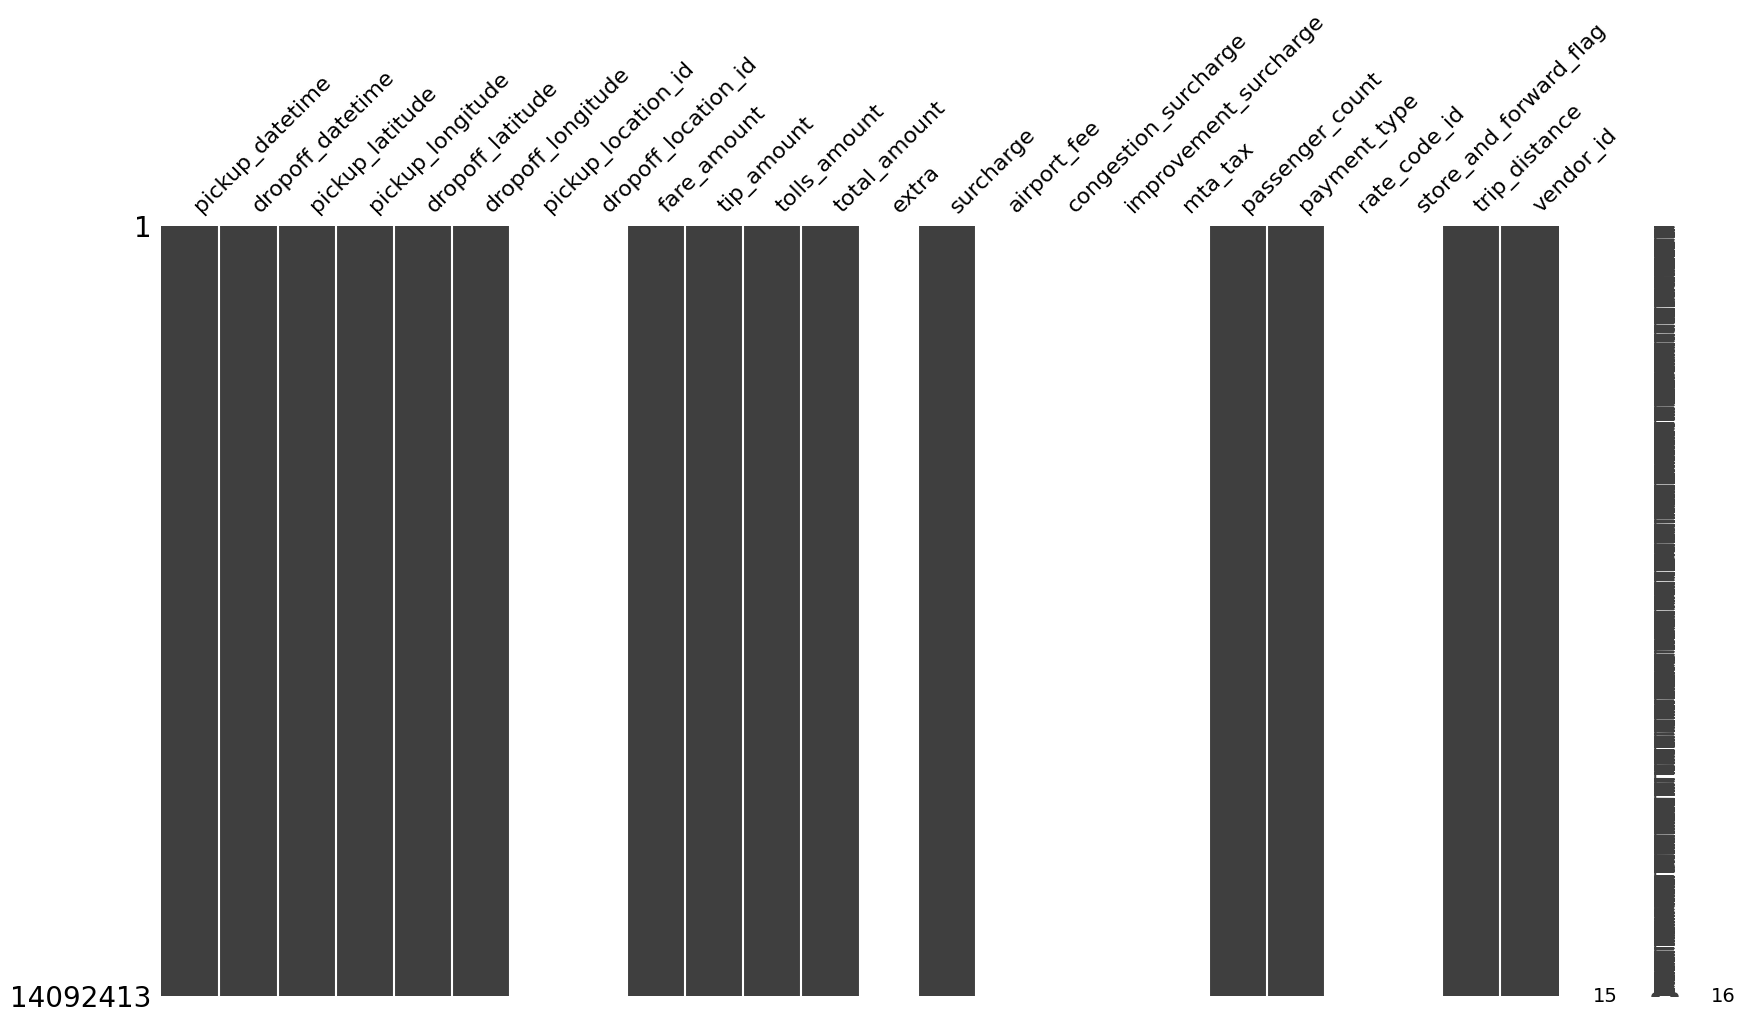

In [21]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data[0].collect().to_pandas(), figsize=(20, 10))
plt.show()